In [1]:
import collections

# load image data
import os
from io import BytesIO

import cv2

# visualization libraries
import matplotlib.pyplot as plt
import numpy as np

# load the labels from the test Excel file in the sign_data folder
import polars as pl
import sklearn
import sklearn.model_selection as model_selection
import tensorflow as tf
from PIL import Image
from skimage import exposure, img_as_float
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import array_to_img, load_img
from tqdm import tqdm

In [2]:
# Import tools and libraries

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


np.random.seed(42)
tf.random.set_seed(42)

Number of classes:  43


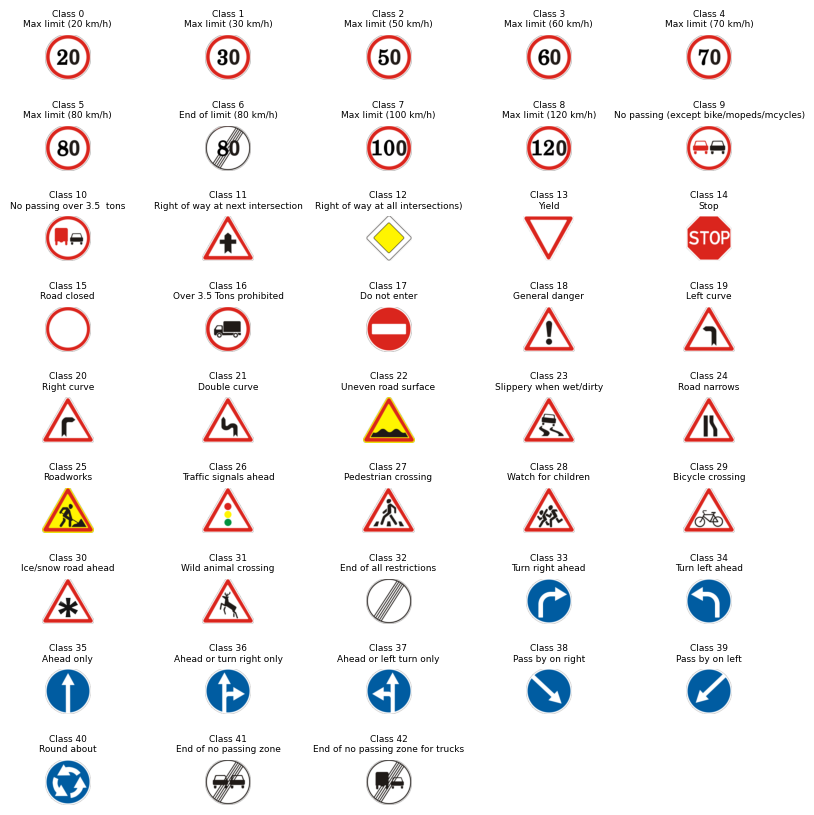

In [3]:
### Load the meta data
dataset_path = "./sign_data/"


def load_meta(path):
    # Read meta data file into a dataframe and order by ClassId
    class_data = pl.read_csv(path + "Meta_full.csv")
    class_data = class_data.sort("ClassId")

    # Get number of classes (number of rows)
    class_rows = class_data.height
    print("Number of classes: ", class_rows)

    return class_data


# display meta data


def display_meta(data, path):
    # Display images from Meta directory in a 6x8 array
    if data is not None:
        fig, ax = plt.subplots(nrows=9, ncols=5, figsize=(10, 10))
        # double space the rows
        fig.subplots_adjust(hspace=1)
        c = 0
        for r, (file, title) in enumerate(zip(data["Path"], data["Description"])):
            ax[r // 5, c % 5].imshow(plt.imread(path + file))
            ax[r // 5, c % 5].axis("off")
            ax[r // 5, c % 5].set_title(f"Class {r}" + "\n" + title, fontsize=6.5)
            c += 1
        # delete the last two axes
        fig.delaxes(ax[8, 3])
        fig.delaxes(ax[8, 4])
        plt.show()


meta_data = load_meta(dataset_path)
display_meta(meta_data, dataset_path)

### GTSRB - German Traffic Sign Recognition Benchmark Dataset

### Data source: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?select=Train.csv

### Open the label file (labels-map-proj-v3.txt) and get the lable lines

### Get Labels Data

In [4]:
# open the train Excel file in the sign_data folder

train_classid = pl.read_parquet("data/train.parquet", use_pyarrow=True, memory_map=True)
test_classid = pl.read_parquet("data/test.parquet", use_pyarrow=True, memory_map=True)
meta_df = pl.read_csv("sign_data/Meta_Full.csv")

In [5]:
# define a function to get the class id and path of the train images into a list


def get_id_path(df):
    image_path = df.select("Path")["Path"].to_list()
    class_id = df.select("ClassId")["ClassId"].to_list()
    return image_path, class_id


train_image_path, train_class_id = get_id_path(train_classid)
test_image_path, test_class_id = get_id_path(test_classid)

print("Total number of train images: ", len(train_image_path))
print("Total number of train class ids: ", len(train_class_id))
print("Total number of test images: ", len(test_image_path))
print("Total number of test class ids: ", len(test_class_id))

print(train_image_path[:2], train_class_id[:2])

Total number of train images:  39209
Total number of train class ids:  39209
Total number of test images:  12630
Total number of test class ids:  12630
['C:\\Users\\teddy\\Documents\\01-Berkeley\\281\\281-final-project\\sign_data\\Train\\20\\00020_00000_00000.png', 'C:\\Users\\teddy\\Documents\\01-Berkeley\\281\\281-final-project\\sign_data\\Train\\20\\00020_00000_00001.png'] [20, 20]


In [6]:
# check for duplicates
test_counts = test_classid["Path"].is_duplicated().sum()
print("Duplicate size:", test_counts)

train_counts = train_classid["Path"].is_duplicated().sum()
print("Duplicate size:", train_counts)

Duplicate size: 0
Duplicate size: 0


In [7]:
# select one sample of each class id in the train_class_id list and find the corresponding image path

unique_class_id_path = train_classid["ClassId"].unique().to_list()
print("Unique ClassId: ", unique_class_id_path)
print("Total number of unique class id: ", len(unique_class_id_path))

Unique ClassId:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
Total number of unique class id:  43


In [8]:
def equalize_histogram(img):
    # HSV version
    img = (img * 255.0).astype(np.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
    img_out = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return img_out


def apply_clahe(img):
    # LAB version
    img = (img * 255.0).astype(np.uint8)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=255, tileGridSize=(8, 8))
    img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
    return cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

In [9]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype="step", color="black")
    ax_hist.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    ax_hist.set_xlabel("Pixel intensity")
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, "r")
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

c:\Users\teddy\Documents\01-Berkeley\281\281-venv\Lib\site-packages\skimage\_shared\utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


Text(0.5, 1.0, 'Histogram equalization')

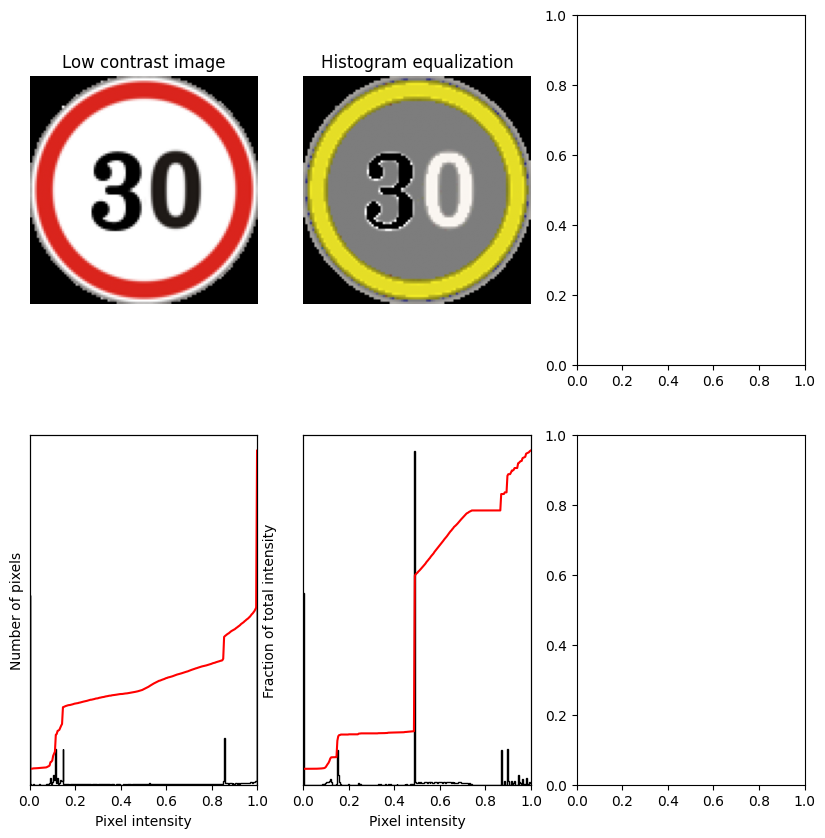

In [10]:
# get 5 images from meta data path
meta_sample = meta_df["Path"].sample(5)

# load the image from the path
img = cv2.imread(dataset_path + meta_sample[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_eq = equalize_histogram(img)
# display the image
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title("Low contrast image")
ax_hist.set_ylabel("Number of pixels")
ax_cdf.set_ylabel("Fraction of total intensity")
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 1])
ax_img.set_title("Histogram equalization")

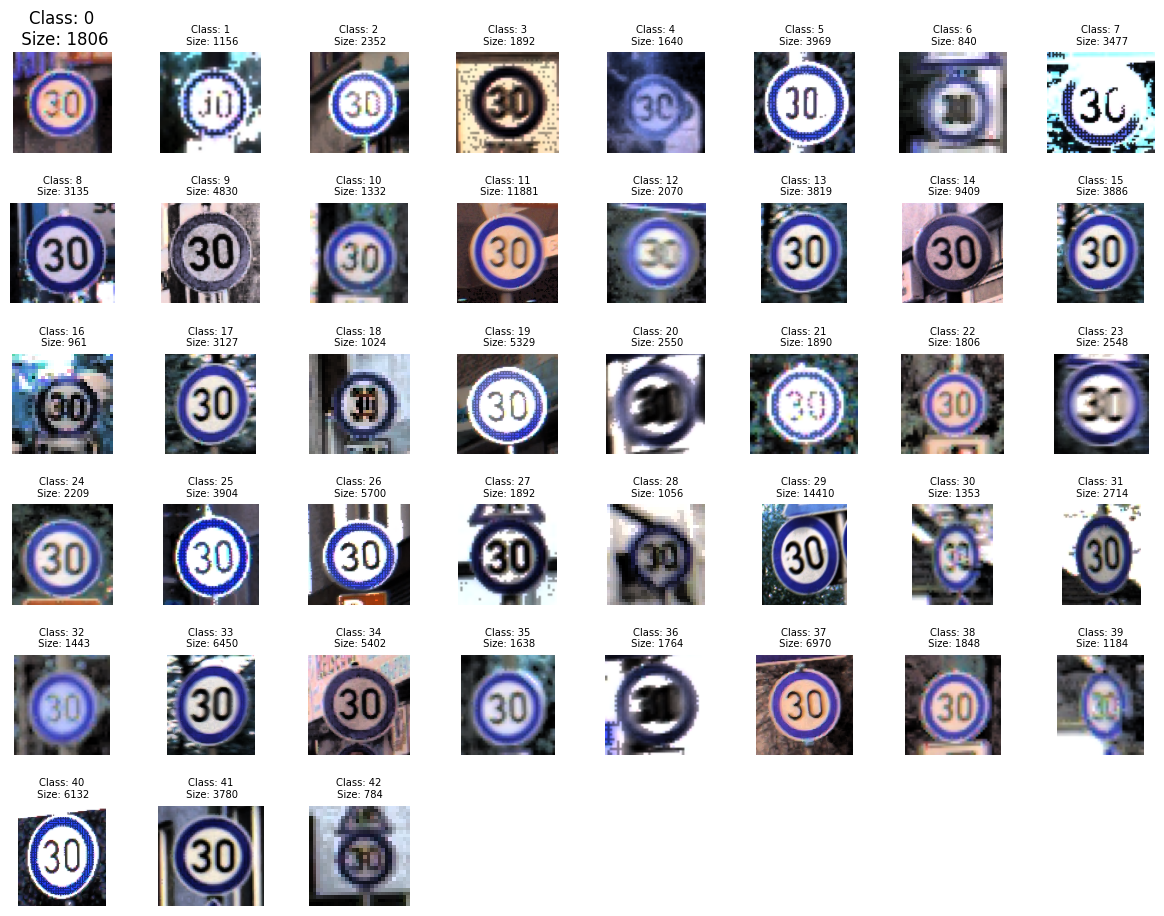

In [11]:
# show the images of the unique class id
plt.figure(figsize=(15, 15))
for i in unique_class_id_path:
    plt.subplot(8, 8, i + 1)
    sampled_row = train_classid.filter(train_classid["ClassId"] == 1).sample(n=1)
    sampled_image = np.load(BytesIO(sampled_row[0]["Image"][0]))
    # plt.imshow(Image.open(unique_class_id_path[i]))
    # plt.imshow(apply_clahe(cv2.imread(unique_class_id_path[i])))
    plt.imshow(equalize_histogram(sampled_image))
    plt.title(i)
    plt.axis("off")
    plt.subplots_adjust(hspace=0.5)
    # split the title into two lines
    plt.title("Class: " + str(i) + "\n Size: " + str(sampled_row[0]["Resolution"][0]))

    # change the fond size of the title
    plt.rcParams.update({"font.size": 6})


plt.show()

Text(0.5, 1.0, 'Distribution of Test Classes')

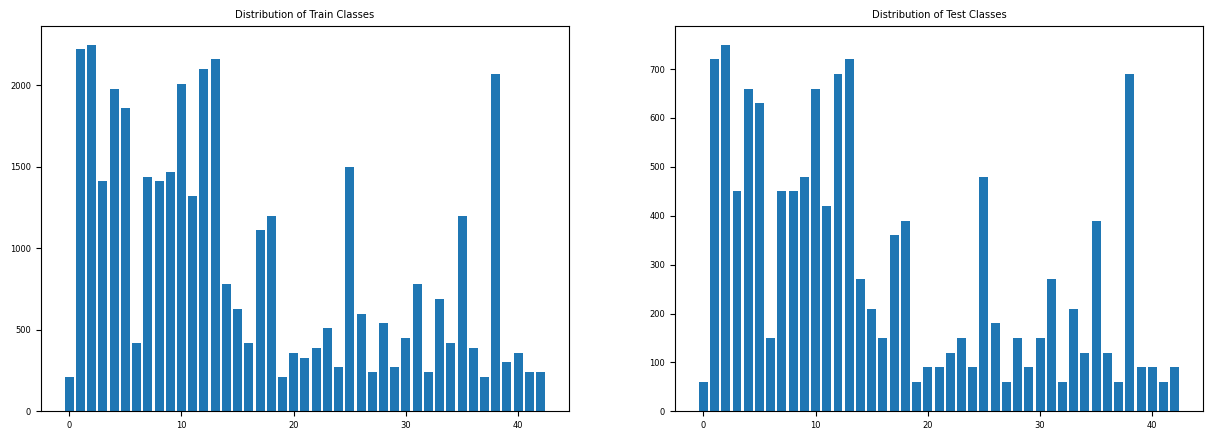

In [12]:
# show the train and test class ids in two separate bar graphs
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(np.unique(train_class_id), np.bincount(train_class_id))
plt.title("Distribution of Train Classes")
plt.subplot(1, 2, 2)
plt.bar(np.unique(test_class_id), np.bincount(test_class_id))
plt.title("Distribution of Test Classes")

In [13]:
# show the count of train and test class counts
print(np.bincount(train_class_id))

print(np.bincount(test_class_id))

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160
  780  630  420 1110 1200  210  360  330  390  510  270 1500  600  240
  540  270  450  780  240  689  420 1200  390  210 2070  300  360  240
  240]
[ 60 720 750 450 660 630 150 450 450 480 660 420 690 720 270 210 150 360
 390  60  90  90 120 150  90 480 180  60 150  90 150 270  60 210 120 390
 120  60 690  90  90  60  90]


#### Observation
- Based on the above bin counts, the minimum count of the 43 classes is 210 for the train dataset.  We will choose a ramdon set of 200 images from each class to set up a sample train dataset for our project.  This uniform sampling will ensure a balanced training dataset. The new train dataset will have 8600 images

- Based on the above bin counts, the minimum count of the classes is 60 for the test dataset.  We will choose a randome set of 60 images from each class to set up a sample test dataset.  The new test dataset will have 2580 images.

In [14]:
# choose a random set of 200 images of each class from the train set
random_sample_size_train = 200
random_sample_size_test = 60

train_sample = train_classid.sample(n=random_sample_size_train, seed=42)
test_sample = test_classid.sample(n=random_sample_size_test, seed=42)


print("Total number of train images: ", train_sample.height)
print("Total number of train class ids: ", train_sample.height)
print("Total number of test images: ", test_sample.height)
print("Total number of test class ids: ", test_sample.height)

Total number of train images:  200
Total number of train class ids:  200
Total number of test images:  60
Total number of test class ids:  60


In [15]:
# use 20% of the train set as the validation set
split_index = int(train_classid.height * 0.8)
train = train_classid.slice(0, split_index)
val = train_classid.slice(split_index)

print("Total number of train images: ", train.height)
print("Total number of train class ids: ", train.height)
print("Total number of validation images: ", val.height)
print("Total number of validation class ids: ", val.height)
print("Total number of test images: ", test_classid.height)
print("Total number of test class ids: ", test_classid.height)

Total number of train images:  31367
Total number of train class ids:  31367
Total number of validation images:  7842
Total number of validation class ids:  7842
Total number of test images:  12630
Total number of test class ids:  12630


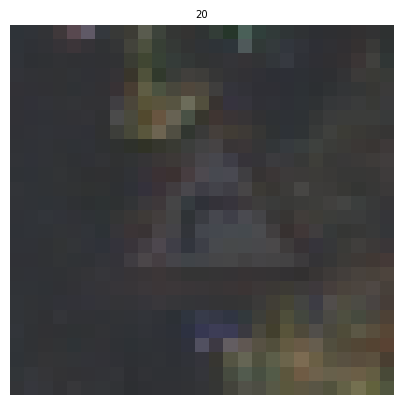

In [16]:
# show one image in the x_val set
plt.imshow(np.load(BytesIO(train[0]["Image"][0])))
plt.title(train[0]["ClassId"][0])
plt.axis("off")
plt.show()

### Based on the bin count of the images, all classes have more than 200 images.  

- To ensure a balanced dataset, we will choose 200 images from each class to create a new train dataset

### Check the image size of the entire dataset

In [17]:
# get the minimum and maximum size of the images in the train and test data
train_image_size = []
print("Minimum size of train image: ")
print(train_classid["Resolution"].min())
print("")
print("Maximum size of train image: ")
print(train_classid["Resolution"].min())


print("")
print("")
print("Minimum size of test image: ")
print(test_classid["Resolution"].min())
print("")
print("Maximum size of test image: ")
print(test_classid["Resolution"].max())

Minimum size of train image: 
625

Maximum size of train image: 
625


Minimum size of test image: 
625

Maximum size of test image: 
61712


In [18]:
# calculate mean and median of the train and test image sizes
print(
    "Mean of train image size: \n",
    train_classid[["Width", "Height", "Resolution"]].mean(),
)
print(
    "Median of train image size: \n",
    train_classid[["Width", "Height", "Resolution"]].median(),
)
print("")
print("")
print(
    "Mean of test image size: \n",
    test_classid[["Width", "Height", "Resolution"]].mean(),
)
print(
    "Median of test image size: \n",
    test_classid[["Width", "Height", "Resolution"]].median(),
)

Mean of train image size: 
 shape: (1, 3)
┌──────────┬──────────┬─────────────┐
│ Width    ┆ Height   ┆ Resolution  │
│ ---      ┆ ---      ┆ ---         │
│ f64      ┆ f64      ┆ f64         │
╞══════════╪══════════╪═════════════╡
│ 50.83588 ┆ 50.32893 ┆ 3109.825525 │
└──────────┴──────────┴─────────────┘
Median of train image size: 
 shape: (1, 3)
┌───────┬────────┬────────────┐
│ Width ┆ Height ┆ Resolution │
│ ---   ┆ ---    ┆ ---        │
│ f64   ┆ f64    ┆ f64        │
╞═══════╪════════╪════════════╡
│ 43.0  ┆ 43.0   ┆ 1849.0     │
└───────┴────────┴────────────┘


Mean of test image size: 
 shape: (1, 3)
┌───────────┬──────────┬─────────────┐
│ Width     ┆ Height   ┆ Resolution  │
│ ---       ┆ ---      ┆ ---         │
│ f64       ┆ f64      ┆ f64         │
╞═══════════╪══════════╪═════════════╡
│ 50.507759 ┆ 50.36445 ┆ 3125.009976 │
└───────────┴──────────┴─────────────┘
Median of test image size: 
 shape: (1, 3)
┌───────┬────────┬────────────┐
│ Width ┆ Height ┆ Resolution │
│

In [19]:
std_img_size = (64, 64)

### Data Preprocessing



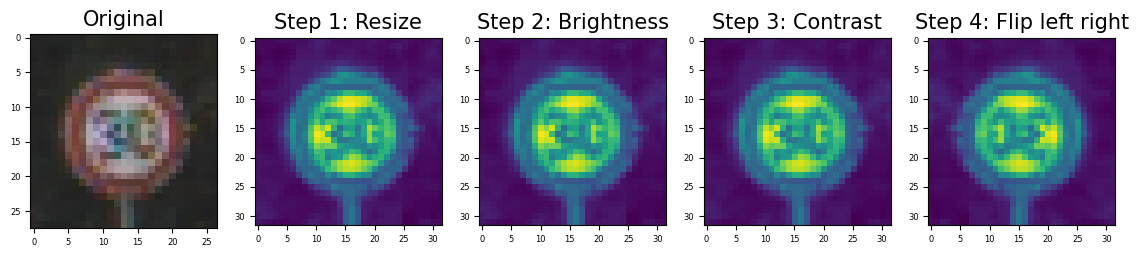

In [20]:
# use one example to explore the image transformation and augmentation techniques
#################################################################################

tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = np.load(BytesIO(train[900]["Image"][0]))

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(image)
ax.set_title("Original", size=15)

# test the image transformation
img_io = tf.io.read_file(train_image_path[900])

# # 2. Decode and convert to grayscale
img_io = tf.io.decode_png(img_io, channels=1)

# 3. Convert to float32 in [0, 1] range
img_io = tf.image.convert_image_dtype(img_io, tf.float32)

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(img_io, size=(32, 32))
ax.imshow(array_to_img(img_resize))
ax.set_title("Step 1: Resize", size=15)

# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title("Step 2: Brightness", size=15)


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title("Step 3: Contrast", size=15)


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title("Step 4: Flip left right", size=15);

### Define a distoration free function to standardize the image size with padding

In [21]:
# Resizing images without distortion

# resize the images to the std_img_size
img_size = std_img_size


def distortion_free_resize(image, img_size):
    w, h = img_size
    # image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True, method="lanczos5") #lanczos5 exhausts memory on dekstop GPU
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # add the same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    # To improve the model accuracy, use the following techniques to
    # adjust brightness, adjust contrast, transpose and flip the images
    image = tf.image.adjust_brightness(image, 0.3)
    image = tf.image.adjust_contrast(image, contrast_factor=3)
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


# define a function to preprocess the images
def apply_distorion_free_process(image_path, img_size):
    resized_image = []
    for i in tqdm(range(len(image_path))):
        image = tf.keras.preprocessing.image.load_img(image_path[i])
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = distortion_free_resize(image, img_size)
        resized_image.append(image)
    resized_image_np = np.array(resized_image)

    return resized_image, resized_image_np

In [22]:
## apply the distortion free process to the train, validation and test set
# this was converted as lazy as possible. There are much more efficient ways to do this. The images are already in
# memory and we're just enabling this old code to go back to disk.
x_train_new, x_train_np = apply_distorion_free_process(
    train["Path"].to_list(), img_size
)


# print the shape of the train, validation and test set
print("Shape of train set: ", x_train_np.shape)

100%|██████████| 31367/31367 [02:50<00:00, 184.41it/s]


Shape of train set:  (31367, 64, 64, 3)


In [23]:
x_val_new, x_val_np = apply_distorion_free_process(val["Path"].to_list(), img_size)
x_test_new, x_test_np = apply_distorion_free_process(
    test_classid["Path"].to_list(), img_size
)

print("Shape of validation set: ", x_val_np.shape)
print("Shape of test set: ", x_test_np.shape)

100%|██████████| 12630/12630 [01:18<00:00, 161.47it/s]


Shape of validation set:  (7842, 64, 64, 3)
Shape of test set:  (12630, 64, 64, 3)


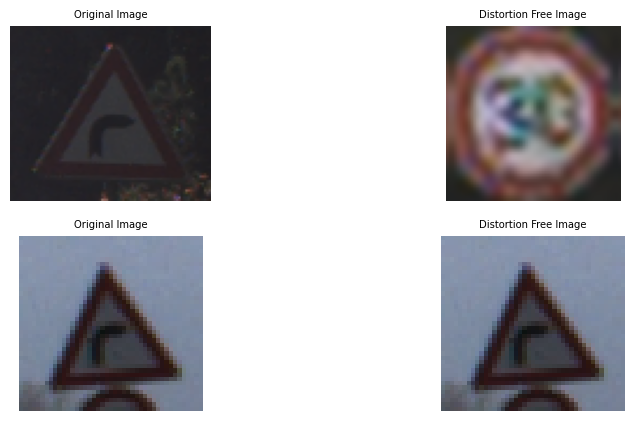

In [24]:
# show 2 images in the train set and compare side by side to the new distortion free images
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(np.load(BytesIO(train[25]["Image"][0])))
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(np.load(BytesIO(train[900]["Scaled_Image"][0])))
plt.title("Distortion Free Image")
plt.axis("off")
plt.subplot(2, 2, 3)
plt.imshow(np.load(BytesIO(train[100]["Image"][0])))
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(np.load(BytesIO(train[100]["Image"][0])))
plt.title("Distortion Free Image")
plt.axis("off")
plt.show()

### Feature Extraction

In [25]:
# Average Pixel Color


# define a function to calculate the average pixel color of the images
def average_pixel_color(image_path):
    avg_pixel_color = []
    for i in tqdm(range(len(image_path))):
        image = tf.keras.preprocessing.image.load_img(image_path[i])
        image = tf.keras.preprocessing.image.img_to_array(image)
        avg_pixel_color.append(np.mean(image, axis=(0, 1)))
    return avg_pixel_color


# calculate the average pixel color of the train, validation and test set
avg_pixel_color_train = average_pixel_color(train["Path"].to_list())
avg_pixel_color_val = average_pixel_color(val["Path"].to_list())
avg_pixel_color_test = average_pixel_color(test_classid["Path"].to_list())

100%|██████████| 12630/12630 [00:10<00:00, 1243.21it/s]


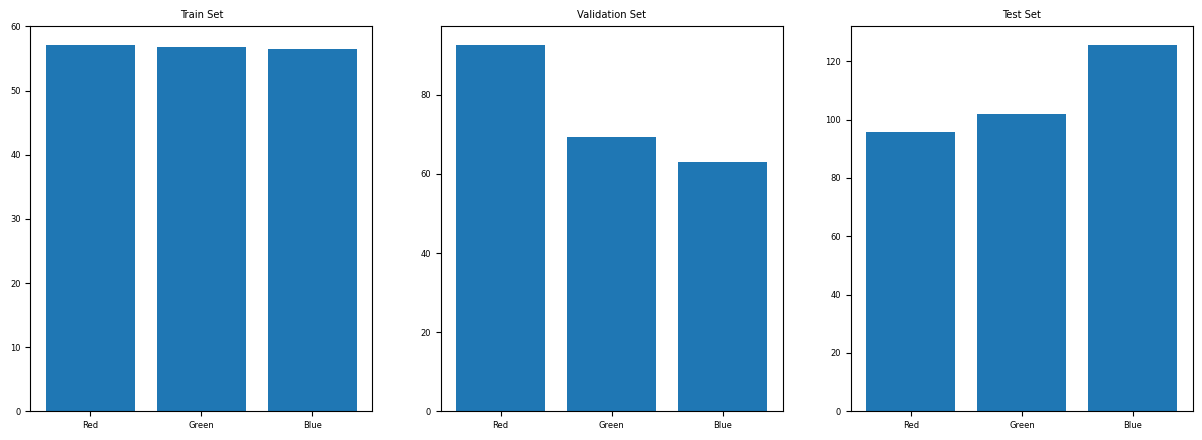

In [26]:
# calculate the average pixel color of the distortion free train, validation and test set for each channel
avg_pixel_color_train_np = np.mean(x_train_np, axis=(1, 2))
avg_pixel_color_val_np = np.mean(x_val_np, axis=(1, 2))
avg_pixel_color_test_np = np.mean(x_test_np, axis=(1, 2))

# plot the average pixel color of the train, validation and test set for each channel
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(np.arange(3), avg_pixel_color_train_np[0])
plt.title("Train Set")
plt.xticks(np.arange(3), ["Red", "Green", "Blue"])
plt.subplot(1, 3, 2)
plt.bar(np.arange(3), avg_pixel_color_val_np[0])
plt.title("Validation Set")
plt.xticks(np.arange(3), ["Red", "Green", "Blue"])
plt.subplot(1, 3, 3)
plt.bar(np.arange(3), avg_pixel_color_test_np[0])
plt.title("Test Set")
plt.xticks(np.arange(3), ["Red", "Green", "Blue"])
plt.show()

In [27]:
## calculate the average pixel color of each class id in the distortion free train set
# avg_pixel_color_train_class = []
# for i in tqdm(range(len(train_classid["ClassId"].unique()))):
#    avg_pixel_color_train_class.append(
#        np.mean(
#            x_train_np[np.where(np.array(y_train) == unique_class_id[i])[0].tolist()],
#            axis=(0, 1, 2),
#        )
#    )

In [28]:
# len(avg_pixel_color_train_class)

In [29]:
# plot the red channel average pixel color of each class id in the distortion free train set
# plt.figure(figsize=(20, 5))
# plt.subplot(1, 3, 1)
# plt.bar(np.arange(43), np.array(avg_pixel_color_train_class)[:, 0])
# plt.title("Red Channel")
# plt.xticks(np.arange(43), unique_class_id, rotation=90)
# plt.subplot(1, 3, 2)
# plt.bar(np.arange(43), np.array(avg_pixel_color_train_class)[:, 1])
# plt.title("Green Channel")
# plt.xticks(np.arange(43), unique_class_id, rotation=90)
# plt.subplot(1, 3, 3)
# plt.bar(np.arange(43), np.array(avg_pixel_color_train_class)[:, 2])
# plt.title("Blue Channel")
# plt.xticks(np.arange(43), unique_class_id, rotation=90)
# plt.show()